In [3]:
import pandas as pd
import seaborn as sns
sns.set_context("talk")
sns.set_style("whitegrid")

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

df = pd.read_csv("endpoints_2.csv")
df = df[np.logical_not(np.in1d(df["catch"],["chiyabi","manchanvwa"]))]
cm = pd.read_csv("calib_map_eye.csv")

df["int_type"] = "All"
df.loc[np.logical_not(df["itn"]),"int_type"] = "No ITN"
df.loc[np.logical_not(df["irs"]),"int_type"] = "No IRS"
df.loc[np.logical_not(df["mda"]),"int_type"] = "No MDA"
df.loc[np.logical_not(df["chw_rcd"]),"int_type"] = "No CHW RCD"
df.loc[np.logical_not(df["chw_hs"]),"int_type"] = "No CHW HS"
df.loc[np.logical_and(np.logical_not(df["chw_rcd"]),np.logical_not(df["chw_hs"])) ,"int_type"] = "No CHW"

cm.rename(columns={"annual_EIR": "historical_annual_EIR","avg_prev": "historical_avg_prev"}, inplace=True)
df = df.merge(cm[["historical_annual_EIR","historical_avg_prev", "catch","sample"]], how="left", on=["catch","sample"])


# Catchments in parameter space:
cdf = df[["catch","sample","arab","funest"]].groupby(["catch","sample"]).median()
cdf.reset_index(inplace=True)

all_df = df[df["int_type"]=="All"]
all_df.rename(columns={"EIR": "EIR_allint",
                      "RDT_prev": "RDT_prev_allint",
                      "cases": "cases_allint"},
             inplace=True)

int_dict = {}
int_dict_2 = {}
for k in ["No ITN", "No IRS", "No MDA", "No CHW", "No CHW HS", "No CHW RCD"]:
    int_dict[k] = df[df["int_type"]==k]
    
    int_dict[k] = int_dict[k].merge(all_df[["catch","sample","Run_Number","EIR_allint","RDT_prev_allint","cases_allint"]],
                                    on=["catch","sample","Run_Number"])
    
#     for j in ["EIR", "RDT_prev","cases"]:
#         int_dict[k]["abs_diff_{}".format(j)] = -int_dict[k]["{}_allint".format(j)]+int_dict[k][j]
#         int_dict[k]["rel_diff_{}".format(j)] = int_dict[k]["abs_diff_{}".format(j)]/int_dict[k]["historical"]
    j = "EIR"
    int_dict[k]["abs_diff_{}".format(j)] = -int_dict[k]["{}_allint".format(j)]+int_dict[k][j]
    int_dict[k]["rel_diff_{}".format(j)] = int_dict[k]["abs_diff_{}".format(j)]/(int_dict[k]["historical_annual_EIR"]-int_dict[k]["EIR_allint"])
    
    
    int_dict[k] = int_dict[k].groupby(["catch","sample"]).agg("median")
    int_dict[k].reset_index(inplace=True)
    int_dict[k]["intervention"] = k[3:]
    
    int_dict_2[k] = int_dict[k].groupby("catch").agg("median").reset_index()
    t = int_dict[k].groupby("catch").agg({"rel_diff_EIR":"std"}).reset_index()
    t.rename(columns={"rel_diff_EIR": "rel_diff_EIR_std"}, inplace=True)
    int_dict_2[k] = int_dict_2[k].merge(t,on="catch")
    int_dict_2[k]["intervention"] = k[3:]
    
    

# label_point(df_iris.sepal_length, df_iris.sepal_width, df_iris.species, plt.gca())  

c:\users\jsuresh\venv\zm-kariba\lib\site-packages\pandas-0.23.3-py3.6-win-amd64.egg\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [4]:
def label_point(x, y, val, ax, x_offset=0.02, y_offset=0):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+x_offset, point['y']+y_offset, str(point['val']))

        
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""
    return plt.cm.get_cmap(base_cmap, N)

In [5]:
num_days = 3*365+7*30

cov_df = pd.read_csv("catch_coverages_2013_onwards.csv")
my_catch_list = list(set(cdf["catch"]))

cov_df = cov_df[np.in1d(cov_df["catch"], my_catch_list)]
# cov_df = cdf[["catch"]].merge(cov_df, how="left",on="catch")
cov_df.reset_index(inplace=True, drop=True)

chw_df = pd.read_csv("../slide_prep/chw_cov.csv")
cov_df = cov_df.merge(chw_df, how="left", on="catch")



cov_df["mda_metric_1"] = np.sqrt(cov_df["mda_med_cov"]*cov_df["mda_max_cov"])
cov_df["mda_metric_2"] = np.sqrt(cov_df["mda_total_cov"]*cov_df["mda_max_cov"])
cov_df["mda_bin"] = "none"
MDA_thresh = np.median(cov_df["mda_metric_1"])
cov_df.loc[cov_df["mda_metric_1"] < MDA_thresh, "mda_bin"] = "low"
cov_df.loc[cov_df["mda_metric_1"] >= MDA_thresh, "mda_bin"] = "high"


cov_df["itn_bin"] = "none"
ITN_thresh = np.median(cov_df["itn_integrated_cov"])
cov_df.loc[cov_df["itn_integrated_cov"] < ITN_thresh, "itn_bin"] = "low"
cov_df.loc[cov_df["itn_integrated_cov"] >= ITN_thresh, "itn_bin"] = "high"

cov_df["irs_bin"] = "none"
# some_IRS = cov_df["irs_max_kill"] >= 0.15
some_IRS = cov_df["irs_integrated_cov"] >= 140
IRS_thresh1 = 140
# IRS_thresh = np.median(cov_df["irs_integrated_cov"][some_IRS])
IRS_thresh2 = 560 # derived visually
cov_df.loc[np.logical_and(cov_df["irs_integrated_cov"] < IRS_thresh2, some_IRS), "irs_bin"] = "low"
cov_df.loc[cov_df["irs_integrated_cov"] >= IRS_thresh2, "irs_bin"] = "high"

cov_df["vc_bin"] = 0
cov_df.loc[np.logical_and(cov_df["itn_bin"] == "low", cov_df["irs_bin"] == "none"), "vc_bin"] = 0

cov_df.loc[np.logical_and(cov_df["itn_bin"] == "high", cov_df["irs_bin"] == "none"), "vc_bin"] = 1
cov_df.loc[np.logical_and(cov_df["itn_bin"] == "low", cov_df["irs_bin"] == "low"), "vc_bin"] = 1

cov_df.loc[np.logical_and(cov_df["itn_bin"] == "high", cov_df["irs_bin"] == "low"), "vc_bin"] = 2
cov_df.loc[np.logical_and(cov_df["itn_bin"] == "low", cov_df["irs_bin"] == "high"), "vc_bin"] = 2

cov_df.loc[np.logical_and(cov_df["itn_bin"] == "high", cov_df["irs_bin"] == "high"), "vc_bin"] = 3

def rescale_cov(v):
    # want mx+b such that min(v) -->0, and max(v) --> 1
    v0 = np.min(v)
    v1 = np.max(v)
    m = 1/(v1-v0)
    b = -m*v0
    return m*v+b
    
cov_df["irs_score"] = rescale_cov(cov_df["irs_max_kill"]/0.9)
cov_df["itn_score"] = rescale_cov(cov_df["itn_integrated_cov"]/num_days)
cov_df["mda_score"] = rescale_cov(cov_df["mda_max_cov"])
cov_df["chw_score"] = rescale_cov(cov_df["diff_youth_effhs"])

cov_df["vc_score"] = cov_df["itn_score"] + cov_df["irs_score"]



FileNotFoundError: File b'catch_coverages_2013_onwards.csv' does not exist

In [6]:
catch_wo_IRS = list(set(cov_df["catch"][cov_df["irs_bin"]=="none"]))
a = int_dict["No MDA"].copy(deep=True)
# plt.scatter(int_dict["No IRS"]["historical_annual_EIR"],int_dict["No IRS"]["abs_diff_EIR"]
temp = a[a["historical_annual_EIR"]<50]
plt.figure(figsize=(15,15))
sns.scatterplot(x="mda_med_cov",y="abs_diff_EIR",hue="catch",size="historical_annual_EIR",data=temp)
# plt.ylim([-50,0])
# plt.xscale('log')

NameError: name 'cov_df' is not defined

In [ ]:
catch_wo_IRS = list(set(cov_df["catch"][cov_df["irs_bin"]=="none"]))

In [2]:
catch_wo_IRS

NameError: name 'catch_wo_IRS' is not defined

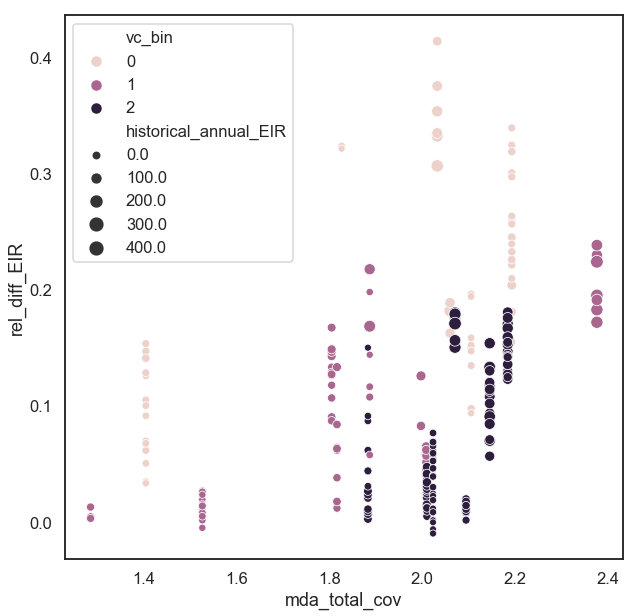

In [5]:
plt.figure(figsize=(10,10))
foo = cov_df.merge(int_dict["No MDA"],on="catch",how="left")
sns.scatterplot("mda_total_cov","rel_diff_EIR",data=foo,hue="vc_bin", size="historical_annual_EIR")

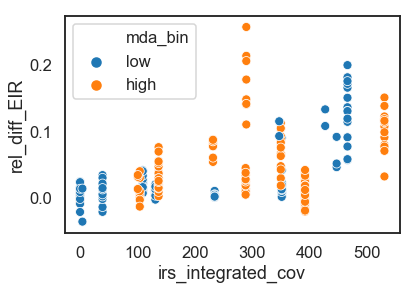

In [6]:
foo = cov_df.merge(int_dict["No IRS"],on="catch",how="left")
sns.scatterplot("irs_integrated_cov","rel_diff_EIR",data=foo, hue="mda_bin")

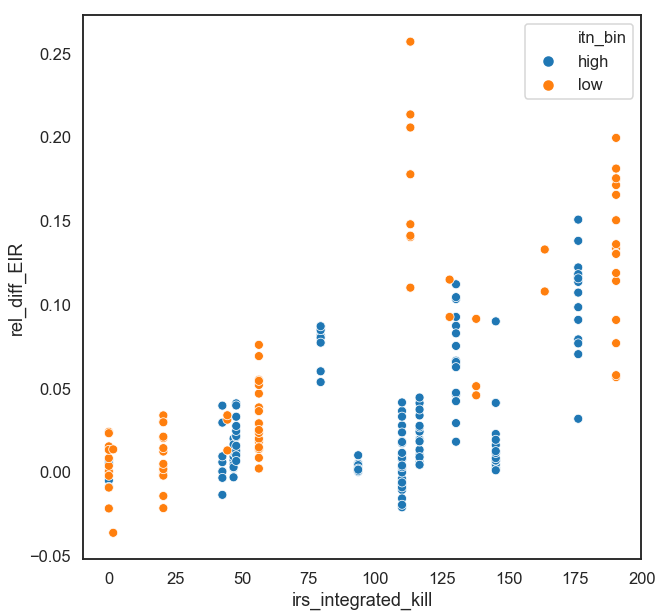

In [7]:
plt.figure(figsize=(10,10))
foo = cov_df.merge(int_dict["No IRS"],on="catch",how="left")
sns.scatterplot("irs_integrated_kill","rel_diff_EIR",data=foo, hue="itn_bin") #, style="mda_bin"

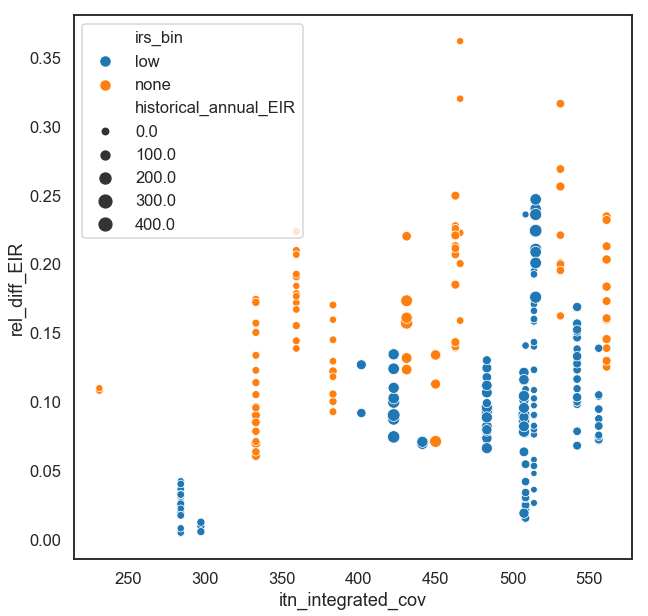

In [8]:
plt.figure(figsize=(10,10))
foo = cov_df.merge(int_dict["No ITN"],on="catch",how="left")
sns.scatterplot("itn_integrated_cov","rel_diff_EIR",data=foo, hue="irs_bin", size="historical_annual_EIR")

In [30]:
foo["itn_integrated_cov"]/num_days

0     0.427913
1     0.385096
2     0.331760
3     0.456241
4     0.245687
5     0.505048
6     0.426762
7     0.431819
8     0.235407
9     0.289936
10    0.400964
11    0.375564
12    0.419049
13    0.422257
14    0.437992
15    0.407019
16    0.233840
17    0.320424
18    0.420937
19    0.393220
20    0.475113
21    0.394825
Name: itn_integrated_cov, dtype: float64

(0, 0.3)

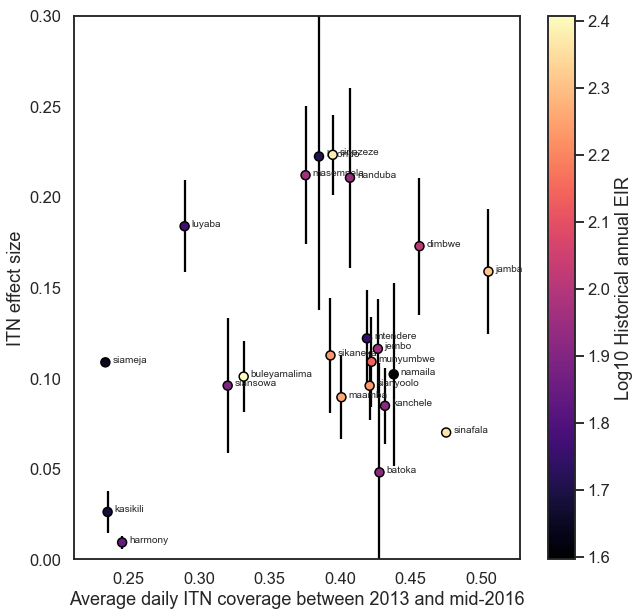

In [45]:
plt.figure(figsize=(10,10))
foo = cov_df.merge(int_dict_2["No ITN"],on="catch",how="left")
plt.scatter(foo["itn_integrated_cov"]/num_days,foo["rel_diff_EIR"],c=np.log10(foo["historical_annual_EIR"]),edgecolors='black',linestyle='None',cmap='magma',zorder=5)
plt.colorbar(label="Log10 Historical annual EIR")

plt.errorbar(foo["itn_integrated_cov"]/num_days,foo["rel_diff_EIR"],yerr=foo["rel_diff_EIR_std"],linestyle='None',color='black')
label_point(foo.itn_integrated_cov/num_days, foo.rel_diff_EIR, foo.catch, plt.gca(),x_offset=0.005)
plt.xlabel("Average daily ITN coverage between 2013 and mid-2016")
plt.ylabel("ITN effect size")
plt.ylim([0,0.3])

(0, 0.2)

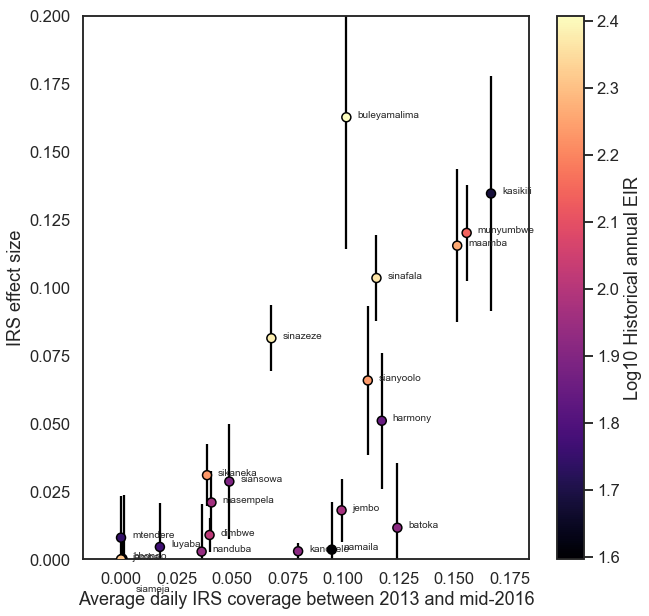

In [46]:
plt.figure(figsize=(10,10))
foo = cov_df.merge(int_dict_2["No IRS"],on="catch",how="left")
# sns.scatterplot("irs_integrated_kill","rel_diff_EIR",data=foo,zorder=5)
plt.scatter(foo["irs_integrated_kill"]/num_days/0.9,foo["rel_diff_EIR"],c=np.log10(foo["historical_annual_EIR"]),edgecolors='black',linestyle='None',cmap='magma',zorder=5)
plt.colorbar(label="Log10 Historical annual EIR")

plt.errorbar(foo["irs_integrated_kill"]/num_days/0.9,foo["rel_diff_EIR"],yerr=foo["rel_diff_EIR_std"],linestyle='None',color='black')
label_point(foo.irs_integrated_kill/num_days/0.9, foo.rel_diff_EIR, foo.catch, plt.gca(),x_offset=0.005)
plt.xlabel("Average daily IRS coverage between 2013 and mid-2016")
plt.ylabel("IRS effect size")
plt.ylim([0,0.2])

(0, 0.2)

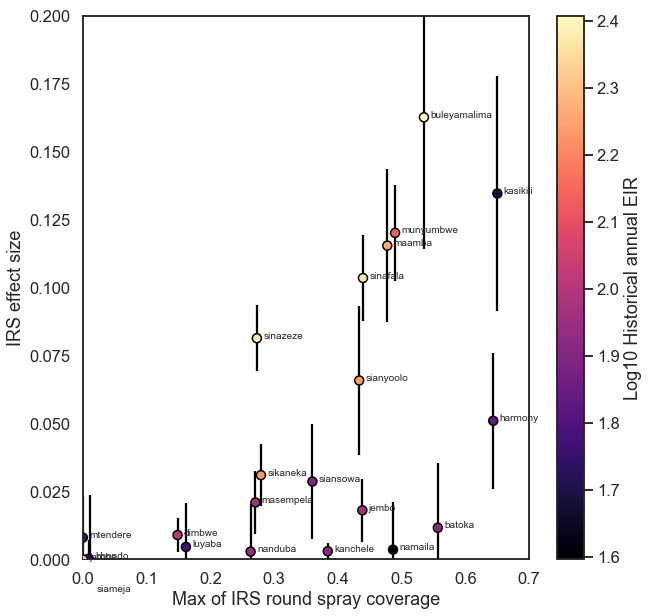

In [66]:
plt.figure(figsize=(10,10))
foo = cov_df.merge(int_dict_2["No IRS"],on="catch",how="left")
# sns.scatterplot("irs_integrated_kill","rel_diff_EIR",data=foo,zorder=5)
plt.scatter(foo["irs_max_kill"]/0.9,foo["rel_diff_EIR"],c=np.log10(foo["historical_annual_EIR"]),edgecolors='black',linestyle='None',cmap='magma',zorder=5)
plt.colorbar(label="Log10 Historical annual EIR")
# c=np.log10(foo["historical_annual_EIR"])

plt.errorbar(foo["irs_max_kill"]/0.9,foo["rel_diff_EIR"],yerr=foo["rel_diff_EIR_std"],linestyle='None',color='black')
label_point(foo.irs_max_kill/0.9, foo.rel_diff_EIR, foo.catch, plt.gca(),x_offset=0.01)
plt.xlabel("Max of IRS round spray coverage")
plt.ylabel("IRS effect size")
plt.xlim([0,0.7])
plt.ylim([0,0.2])

(0, 0.4)

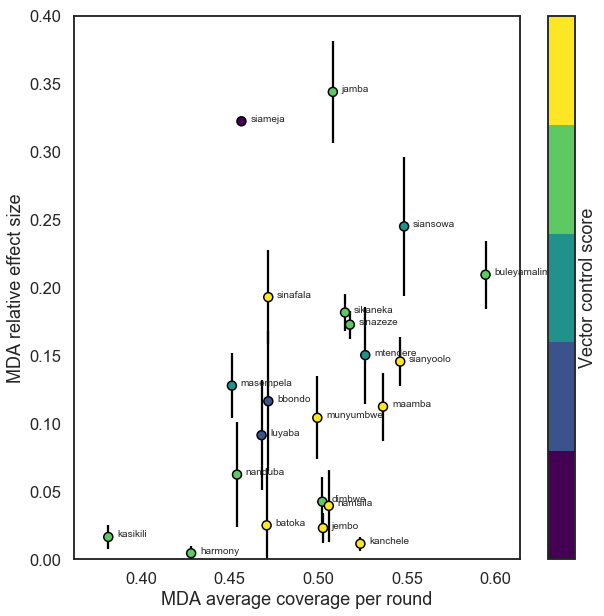

In [134]:
plt.figure(figsize=(10,10))
foo = cov_df.merge(int_dict_2["No MDA"],on="catch",how="left")
# sns.scatterplot("mda_total_cov","rel_diff_EIR",data=foo,zorder=5,hue="irs_max_kill")
plt.scatter(foo["mda_total_cov"]/foo["mda_rounds"],foo["rel_diff_EIR"],c=foo["vc_score"],edgecolors='black',linestyle='None',zorder=5,  cmap=discrete_cmap(5,"viridis"))
# c=np.log10(foo["historical_annual_EIR"])

cb = plt.colorbar(label="Vector control score",ticks=[])
# cb.set_yticklabels([])
plt.errorbar(foo["mda_total_cov"]/foo["mda_rounds"],foo["rel_diff_EIR"],yerr=foo["rel_diff_EIR_std"],linestyle='None',color='black')
label_point(foo["mda_total_cov"]/foo["mda_rounds"], foo.rel_diff_EIR, foo.catch, plt.gca(),x_offset=0.005)
plt.xlabel("MDA average coverage per round")
plt.ylabel("MDA relative effect size")
plt.ylim([0,0.4])

(0, 0.4)

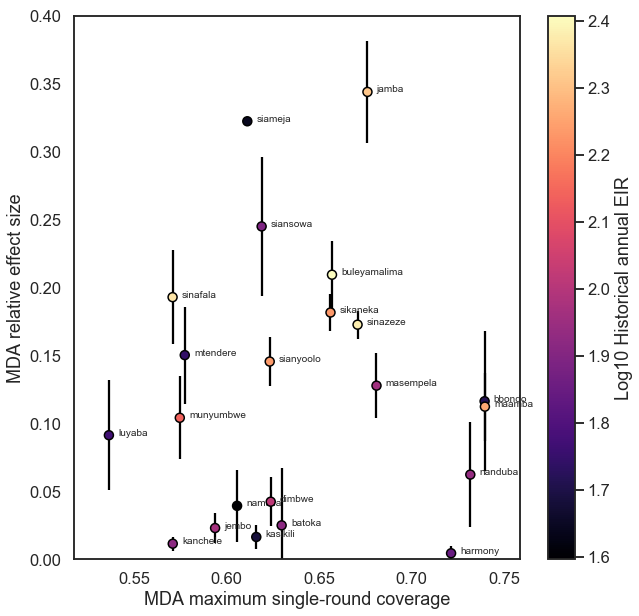

In [105]:
plt.figure(figsize=(10,10))
foo = cov_df.merge(int_dict_2["No MDA"],on="catch",how="left")
# sns.scatterplot("mda_total_cov","rel_diff_EIR",data=foo,zorder=5,hue="irs_max_kill")
plt.scatter(foo["mda_max_cov"],foo["rel_diff_EIR"],c=np.log10(foo["historical_annual_EIR"]),edgecolors='black',linestyle='None',cmap='magma',zorder=5)
plt.colorbar(label="Log10 Historical annual EIR")
plt.errorbar(foo["mda_max_cov"],foo["rel_diff_EIR"],yerr=foo["rel_diff_EIR_std"],linestyle='None',color='black')
label_point(foo.mda_max_cov, foo.rel_diff_EIR, foo.catch, plt.gca(),x_offset=0.005)
plt.xlabel("MDA maximum single-round coverage")
plt.ylabel("MDA relative effect size")
plt.ylim([0,0.4])

# CHW

In [135]:
chw_df = pd.read_csv("../slide_prep/chw_cov.csv")
cov_df = cov_df.merge(chw_df, how="left", on="catch")

In [272]:
cov_df

,catch,irs_integrated_cov,irs_integrated_kill,irs_max_cov,irs_max_kill,itn_integrated_block,itn_integrated_cov,itn_integrated_cov_eff,itn_integrated_kill,itn_max_block,...,irs_bin,vc_bin,vc_integrated_kill,diff_adult_effhs,diff_youth_effhs,post_adult_effhs,post_youth_effhs,pre_adult_effhs,pre_youth_effhs,trigger_coverage
0,batoka,488.383907,165.237963,0.802281,0.500990,455.194193,1072.431604,798.720684,373.168316,0.499375,...,low,2,538.406278,0.008441,0.016883,0.313954,0.627907,0.305512,0.611024,0.702469
1,bbondo,23.144125,0.745999,0.016449,0.008225,560.027906,1290.408878,958.692414,454.144490,0.557746,...,none,1,454.890489,0.076800,0.153601,0.357728,0.715457,0.280928,0.561856,0.702469
2,buleyamalima,624.086193,140.410313,0.831925,0.481341,404.402747,1032.949634,762.468345,341.224122,0.441775,...,high,2,481.634435,0.066361,0.132722,0.339889,0.679777,0.273528,0.547055,0.231748
3,dimbwe,176.368616,52.142247,0.297393,0.133706,496.226839,1131.332455,840.177951,400.896376,0.661348,...,low,2,453.038623,0.036836,0.073671,0.334340,0.668680,0.297504,0.595009,0.603333
4,harmony,569.978518,142.125243,0.810277,0.579208,349.833115,917.703763,680.835977,298.371484,0.436923,...,high,2,440.496727,0.012794,0.025589,0.369493,0.738986,0.356698,0.713397,0.702469
5,jamba,0.000000,0.000000,0.000000,0.000000,483.748117,1152.047013,851.933748,397.986240,0.458158,...,none,1,397.986240,0.073955,0.147909,0.350403,0.700806,0.276449,0.552897,0.603333
6,jembo,399.456062,131.847777,0.669230,0.394484,463.106487,1079.530301,799.992968,377.848247,0.566986,...,low,2,509.696024,0.022255,0.044510,0.281354,0.562709,0.259100,0.518199,0.676254
7,kanchele,327.572612,107.105696,0.606409,0.345698,463.898283,1082.577508,800.582274,378.288531,0.568377,...,low,2,485.394228,0.052600,0.105200,0.304574,0.609149,0.251974,0.503948,0.676254
8,kasikili,836.507090,226.641817,0.978780,0.585146,310.565796,803.051950,596.571089,264.137325,0.353163,...,high,2,490.779141,0.022503,0.045007,0.290752,0.581505,0.268249,0.536498,0.676254
9,luyaba,70.436887,26.465448,0.190797,0.145540,336.731771,875.509769,646.738251,286.535117,0.409322,...,none,0,313.000565,0.048798,0.097595,0.301345,0.602689,0.252547,0.505094,0.702469


Text(0.5, 0, 'Difference in u5 effective health-seeking rate from CHW addition')

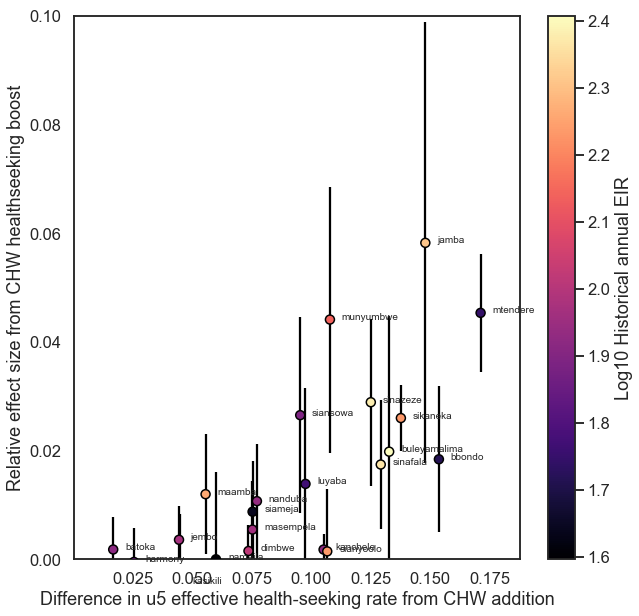

In [253]:
plt.figure(figsize=(10,10))
x = "diff_youth_effhs"
y = "rel_diff_EIR"
yerr = "rel_diff_EIR_std"
c = "historical_annual_EIR"

foo = cov_df.merge(int_dict_2["No CHW HS"],on="catch",how="left")
# sns.scatterplot("mda_total_cov","rel_diff_EIR",data=foo,zorder=5,hue="irs_max_kill")
plt.scatter(foo[x],foo[y],c=np.log10(foo[c]),edgecolors='black',linestyle='None',cmap='magma',zorder=5)
plt.colorbar(label="Log10 Historical annual EIR")
plt.errorbar(foo[x],foo[y],yerr=foo[yerr],linestyle='None',color='black')
label_point(foo.diff_youth_effhs, foo.rel_diff_EIR, foo.catch, plt.gca(),x_offset=0.005)
# plt.xlabel("MDA TOTAL coverage (sum over all rounds)")
plt.ylim([0,0.1])
plt.ylabel("Relative effect size from CHW healthseeking boost")
plt.xlabel("Difference in u5 effective health-seeking rate from CHW addition")

Text(0.5, 0, 'Effective RCD trigger rate (u5 health-seeking rate * CHW case coverage)')

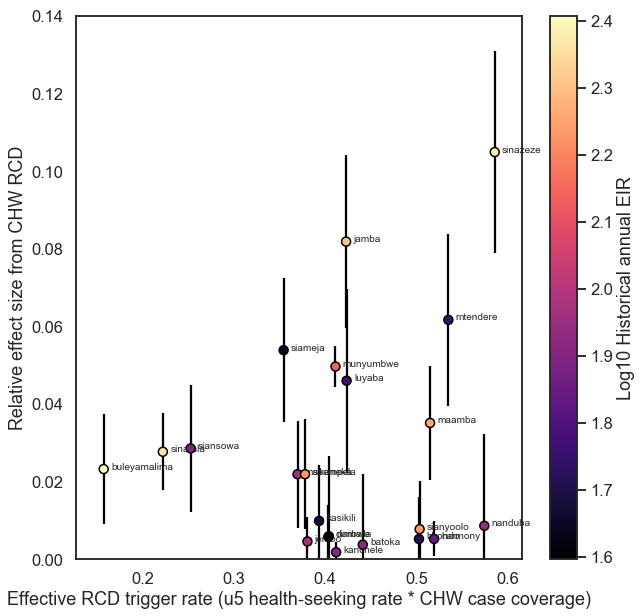

In [285]:
plt.figure(figsize=(10,10))
x = "rcd_trigger_youth"
y = "rel_diff_EIR"
yerr = "rel_diff_EIR_std"
c = "historical_annual_EIR"

foo = cov_df.merge(int_dict_2["No CHW RCD"],on="catch",how="left")
# sns.scatterplot("mda_total_cov","rel_diff_EIR",data=foo,zorder=5,hue="irs_max_kill")
plt.scatter(foo[x],foo[y],c=np.log10(foo[c]),edgecolors='black',linestyle='None',cmap='magma',zorder=5)
plt.colorbar(label="Log10 Historical annual EIR")
plt.errorbar(foo[x],foo[y],yerr=foo[yerr],linestyle='None',color='black')
label_point(foo.rcd_trigger_youth, foo.rel_diff_EIR, foo.catch, plt.gca(),x_offset=0.008)
plt.ylim([0,0.14])
plt.ylabel("Relative effect size from CHW RCD")
plt.xlabel("Effective RCD trigger rate (u5 health-seeking rate * CHW case coverage)")

Text(0.5, 0, 'u5 difference in health-seeking rate after adding CHW')

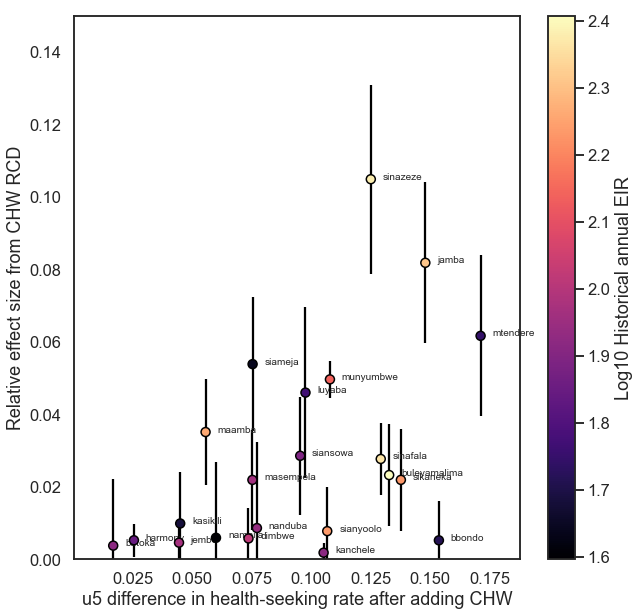

In [266]:
plt.figure(figsize=(10,10))
x = "diff_youth_effhs"
y = "rel_diff_EIR"
yerr = "rel_diff_EIR_std"
c = "historical_annual_EIR"

foo = cov_df.merge(int_dict_2["No CHW RCD"],on="catch",how="left")
# sns.scatterplot("mda_total_cov","rel_diff_EIR",data=foo,zorder=5,hue="irs_max_kill")
plt.scatter(foo[x],foo[y],c=np.log10(foo[c]),edgecolors='black',linestyle='None',cmap='magma',zorder=5)
plt.colorbar(label="Log10 Historical annual EIR")
plt.errorbar(foo[x],foo[y],yerr=foo[yerr],linestyle='None',color='black')
label_point(foo.diff_youth_effhs, foo.rel_diff_EIR, foo.catch, plt.gca(),x_offset=0.005)
# plt.xlabel("MDA TOTAL coverage (sum over all rounds)")
plt.ylim([0,0.15])
plt.ylabel("Relative effect size from CHW RCD")
plt.xlabel("u5 difference in health-seeking rate after adding CHW")

Text(0.5, 0, 'Difference in u5 effective health-seeking rate from CHW addition')

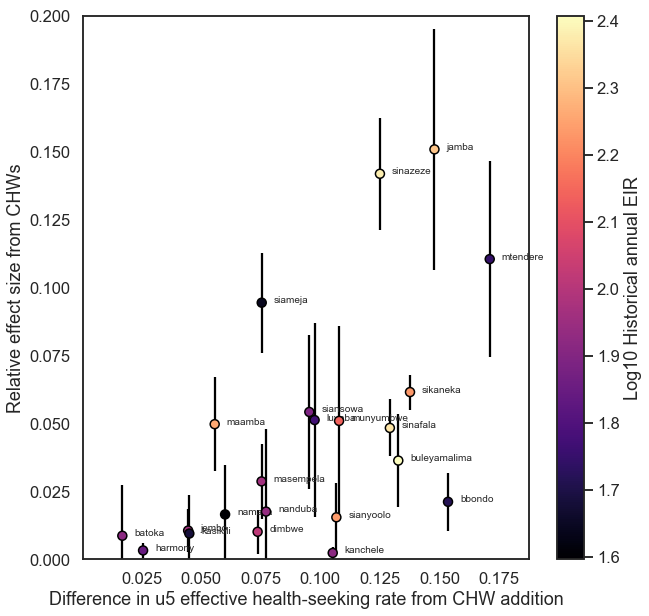

In [286]:
plt.figure(figsize=(10,10))
x = "diff_youth_effhs"
y = "rel_diff_EIR"
yerr = "rel_diff_EIR_std"
c = "historical_annual_EIR"

foo = cov_df.merge(int_dict_2["No CHW"],on="catch",how="left")
# sns.scatterplot("mda_total_cov","rel_diff_EIR",data=foo,zorder=5,hue="irs_max_kill")
plt.scatter(foo[x],foo[y],c=np.log10(foo[c]),edgecolors='black',linestyle='None',cmap='magma',zorder=5)
plt.colorbar(label="Log10 Historical annual EIR")
plt.errorbar(foo[x],foo[y],yerr=foo[yerr],linestyle='None',color='black')
label_point(foo.diff_youth_effhs, foo.rel_diff_EIR, foo.catch, plt.gca(),x_offset=0.005)
plt.ylim([0,0.2])
plt.ylabel("Relative effect size from CHWs")
plt.xlabel("Difference in u5 effective health-seeking rate from CHW addition")

Text(0.5, 0, 'HS impact')

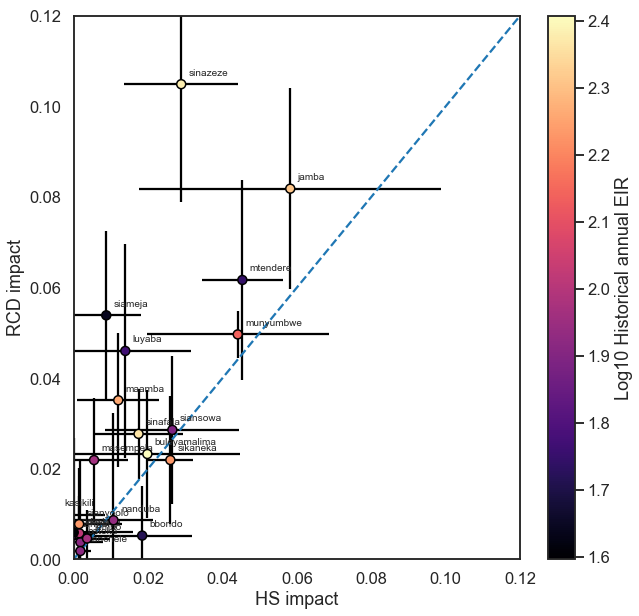

In [298]:
plt.figure(figsize=(10,10))
x = "diff_youth_effhs"
y = "rel_diff_EIR"
yerr = "rel_diff_EIR_std"
c = "historical_annual_EIR"
foo1 = cov_df.merge(int_dict_2["No CHW HS"],on="catch",how="left")
foo2 = cov_df.merge(int_dict_2["No CHW RCD"],on="catch",how="left")

plt.scatter(foo1[y],foo2[y],c=np.log10(foo1[c]),edgecolors='black',linestyle='None',cmap='magma',zorder=5)
plt.colorbar(label="Log10 Historical annual EIR")
plt.errorbar(foo1[y],foo2[y],xerr=foo1[yerr],yerr=foo2[yerr],linestyle='None',color='black')
label_point(foo1.rel_diff_EIR, foo2.rel_diff_EIR, foo1.catch, plt.gca(),x_offset=0.002, y_offset=0.002)
# plt.ylim([0,0.2])
plt.plot([0,1],[0,1],linestyle='dashed')
plt.xlim([0,0.12])
plt.ylim([0,0.12])
plt.ylabel("RCD impact")
plt.xlabel("HS impact")

Text(0, 0.5, 'Full CHW impact')

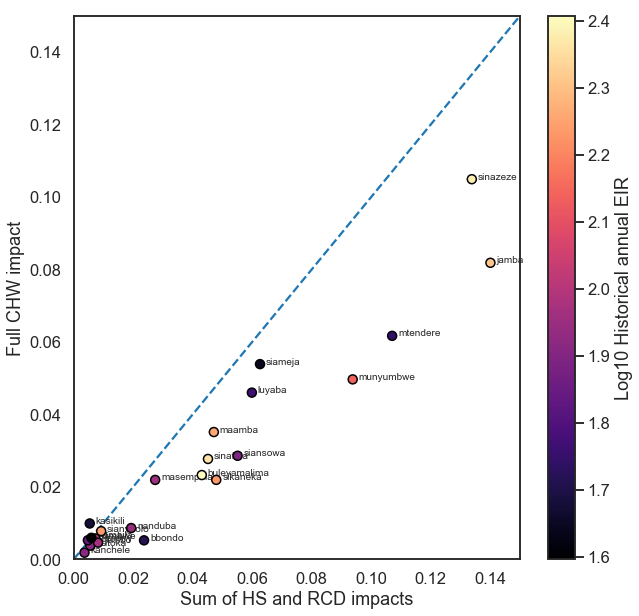

In [308]:
plt.figure(figsize=(10,10))
x = "diff_youth_effhs"
y = "rel_diff_EIR"
yerr = "rel_diff_EIR_std"
c = "historical_annual_EIR"
foo1 = cov_df.merge(int_dict_2["No CHW HS"],on="catch",how="left")
foo2 = cov_df.merge(int_dict_2["No CHW RCD"],on="catch",how="left")
foo3 = cov_df.merge(int_dict_2["No CHW RCD"],on="catch",how="left")

plt.scatter(foo1[y]+foo2[y],foo3[y],c=np.log10(foo1[c]),edgecolors='black',linestyle='None',cmap='magma',zorder=5)
plt.colorbar(label="Log10 Historical annual EIR")
# plt.errorbar(foo1[y],foo2[y],xerr=foo1[yerr],yerr=foo2[yerr],linestyle='None',color='black')
label_point(foo1.rel_diff_EIR+foo2.rel_diff_EIR, foo3.rel_diff_EIR, foo1.catch, plt.gca(),x_offset=0.002)
# plt.ylim([0,0.2])
plt.plot([0,1],[0,1],linestyle='dashed')
plt.xlim([0,0.15])
plt.ylim([0,0.15])
plt.xlabel("Sum of HS and RCD impacts")
plt.ylabel("Full CHW impact")


In [14]:
foo

,catch,irs_integrated_cov,irs_integrated_kill,irs_max_cov,irs_max_kill,itn_integrated_block,itn_integrated_cov,itn_integrated_cov_eff,itn_integrated_kill,itn_max_block,...,msat,true_prev,historical_annual_EIR,historical_avg_prev,EIR_allint,RDT_prev_allint,cases_allint,abs_diff_EIR,rel_diff_EIR,rel_diff_EIR_std
0,batoka,351.185542,145.187272,0.801317,0.501761,246.292161,508.475940,382.027789,192.198012,0.497234,...,True,0.039206,82.896435,0.275265,0.971117,0.011997,346.5,3.746124,0.047980,0.060322
1,bbondo,0.000000,0.000000,0.000000,0.000000,221.523986,465.898896,348.300717,174.103758,0.566473,...,True,0.174667,51.944084,0.247169,0.947956,0.029257,257.0,13.201879,0.222316,0.084989
2,buleyamalima,289.499557,113.139782,0.751180,0.483197,194.928892,422.626390,311.801276,154.508793,0.435523,...,True,0.139397,255.479108,0.302449,33.481303,0.136986,4116.0,21.234030,0.100833,0.019656
3,dimbwe,131.164877,46.801267,0.297393,0.133706,280.251799,561.222522,419.034064,215.015050,0.664078,...,True,0.144888,103.763004,0.389041,1.162333,0.018868,232.0,17.464781,0.172792,0.037707
4,harmony,446.816426,137.841575,0.810277,0.579208,143.453083,297.144599,222.459486,112.050984,0.402079,...,True,0.015279,69.795624,0.316668,0.096208,0.018936,134.0,0.640085,0.009304,0.003422
5,jamba,0.000000,0.000000,0.000000,0.000000,190.446964,431.064261,315.874950,153.590457,0.456531,...,True,0.228956,204.898605,0.396925,31.533867,0.245358,1627.5,25.018653,0.158807,0.034473
6,jembo,288.297728,116.590281,0.665291,0.394484,263.442059,542.021699,404.090652,204.536808,0.579021,...,True,0.081321,93.317838,0.381448,1.341664,0.009467,212.0,9.889466,0.116152,0.027387
7,kanchele,234.333026,93.562908,0.605693,0.345712,269.442567,556.108233,412.393214,208.988958,0.580139,...,True,0.072834,82.898559,0.354335,0.370967,0.004242,184.0,7.337920,0.084699,0.020952
8,kasikili,465.706193,190.335784,0.968330,0.584052,131.652800,284.035075,212.630469,104.723706,0.285599,...,True,0.023443,48.132569,0.293823,1.481931,0.014688,292.0,1.280151,0.026122,0.011635
9,luyaba,39.125895,20.451682,0.188987,0.145540,164.326138,359.242252,266.235993,131.058588,0.400875,...,True,0.145839,58.919687,0.322282,3.458823,0.049647,974.0,9.394799,0.183803,0.025513


In [141]:


def get_spline(colx,coly,data):
    x = np.array(data[colx])
    y = np.array(data[coly])
    
    sx = np.argsort(x)
    x = x[sx]
    y = y[sx]
    
    f = interp1d(x, y, kind='cubic')
    
    return f

def get_polyfit(colx,coly,data,n=3):
    x = np.array(data[colx])
    y = np.array(data[coly])
    
    sx = np.argsort(x)
    x = x[sx]
    y = y[sx]
    
    f = np.poly1d(np.polyfit(x, y, n))
    
    return f

(0, 0.42)

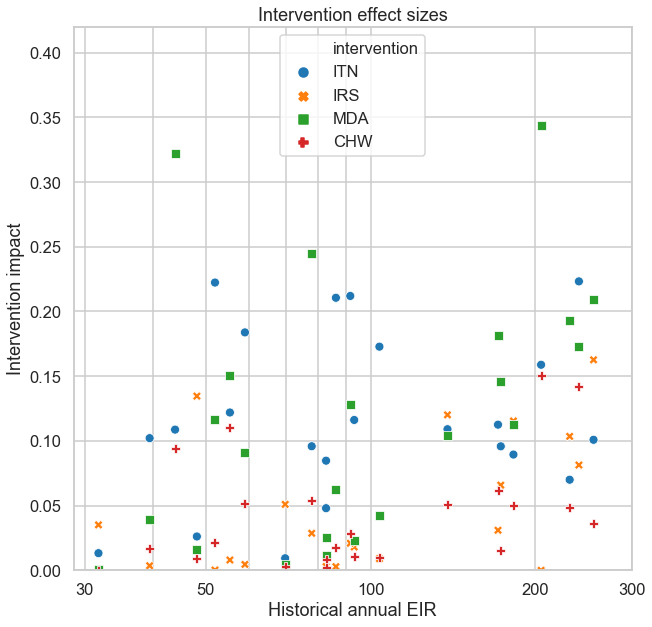

In [184]:
plt.figure(figsize=(10,10))

foo = pd.concat(list(int_dict_2.values()))
temp = foo[np.logical_and(foo["intervention"] != "CHW HS", foo["intervention"] != "CHW RCD")]

sns.scatterplot(x="historical_annual_EIR",y="rel_diff_EIR",hue="intervention",data=temp,style="intervention")
# sns.lmplot(x="historical_annual_EIR",y="abs_diff_EIR",hue="intervention",data=foo)
plt.title("Intervention effect sizes")
plt.ylabel("Intervention impact")
plt.xlabel("Historical annual EIR")

# plt.ylim([-20,0])
plt.xscale('log')
# plt.xlim([30,300])
plt.xticks([30,40,50,60,70,80,90,100,200,300],labels=[30,None,50,None,None,None,None,100,200,300])
plt.ylim([0,0.42])
# plt.xlim([20,100])

# f = get_polyfit("historical_annual_EIR","rel_diff_EIR",foo[foo["intervention"]=="ITN"])
# xs = np.linspace(10,300,100)
# ys = f(xs)
# plt.plot(xs,ys,linestyle='dashed',color='C0')

# f = get_polyfit("historical_annual_EIR","rel_diff_EIR",foo[foo["intervention"]=="IRS"])
# xs = np.linspace(10,300,100)
# ys = f(xs)
# plt.plot(xs,ys,linestyle='dashed',color='C1')

# f = get_polyfit("historical_annual_EIR","rel_diff_EIR",foo[foo["intervention"]=="MDA"])
# xs = np.linspace(10,300,100)
# ys = f(xs)
# plt.plot(xs,ys,linestyle='dashed',color='C2')

# f = get_polyfit("historical_annual_EIR","rel_diff_EIR",foo[foo["intervention"]=="CHW"])
# xs = np.linspace(10,300,100)
# ys = f(xs)
# plt.plot(xs,ys,linestyle='dashed',color='C3')


c:\users\jsuresh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\jsuresh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
c:\users\jsuresh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.

(0, 0.35)

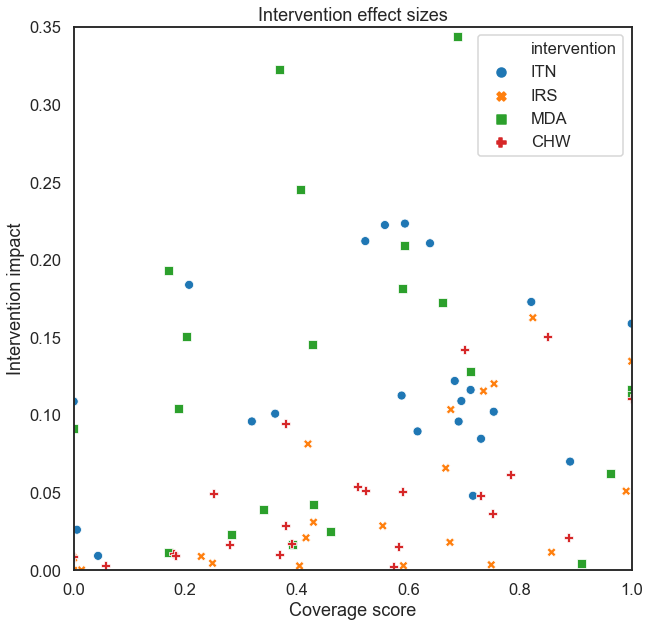

In [160]:
plt.figure(figsize=(10,10))

foo = pd.concat(list(int_dict_2.values()))
temp = foo[np.logical_and(foo["intervention"] != "CHW HS", foo["intervention"] != "CHW RCD")]
temp = temp.merge(cov_df[["catch","itn_score","irs_score","chw_score","mda_score"]],how="left",on="catch")

temp["cov_score"] = 0
temp["cov_score"][temp["intervention"]=="ITN"] = temp["itn_score"][temp["intervention"]=="ITN"]
temp["cov_score"][temp["intervention"]=="IRS"] = temp["irs_score"][temp["intervention"]=="IRS"]
temp["cov_score"][temp["intervention"]=="MDA"] = temp["mda_score"][temp["intervention"]=="MDA"]
temp["cov_score"][temp["intervention"]=="CHW"] = temp["chw_score"][temp["intervention"]=="CHW"]

sns.scatterplot(x="cov_score",y="rel_diff_EIR",hue="intervention",data=temp,style="intervention")
# plt.errorbar()
plt.title("Intervention effect sizes")
plt.ylabel("Intervention impact")
plt.xlabel("Coverage score")
plt.xlim([0,1])
plt.ylim([0,0.35])


In [177]:
foo = pd.concat(list(int_dict_2.values()))
temp = foo[np.logical_and(foo["intervention"] != "CHW HS", foo["intervention"] != "CHW RCD")]

s = temp.groupby("catch").agg({"rel_diff_EIR":"sum"})

In [186]:
temp[["catch","historical_annual_EIR"]]

,catch,historical_annual_EIR
0,batoka,82.896435
1,bbondo,51.944084
2,buleyamalima,255.479108
3,dimbwe,103.763004
4,harmony,69.795624
5,jamba,204.898605
6,jembo,93.317838
7,kanchele,82.898559
8,kasikili,48.132569
9,luyaba,58.919687


In [162]:
cov_df

,catch,irs_integrated_cov,irs_integrated_kill,irs_max_cov,irs_max_kill,itn_integrated_block,itn_integrated_cov,itn_integrated_cov_eff,itn_integrated_kill,itn_max_block,...,mda_metric_2,mda_bin,itn_bin,irs_bin,vc_bin,irs_score,itn_score,mda_score,chw_score,vc_score
0,batoka,366.641190,146.092989,0.802281,0.500990,271.902057,558.426556,421.300768,211.962693,0.503598,...,1.088928,low,high,low,2,0.856335,0.715588,0.459425,0.000000,1.571923
1,bbondo,20.643836,0.745998,0.016449,0.008225,236.755205,502.549769,375.892397,186.773386,0.569927,...,1.181259,high,low,none,0,0.014058,0.557711,0.999246,0.886494,0.571769
2,buleyamalima,408.258422,119.119448,0.821169,0.481397,199.374447,432.946421,319.734138,158.180085,0.436230,...,1.249658,high,low,low,1,0.822844,0.361050,0.593326,0.751113,1.183894
3,dimbwe,131.164877,46.801267,0.297393,0.133706,298.083793,595.393884,445.552954,228.613014,0.666514,...,1.119418,low,high,none,1,0.228541,0.820038,0.430400,0.368224,1.048579
4,harmony,446.816426,137.841575,0.810277,0.579208,153.675573,320.620924,240.307814,120.447106,0.409024,...,0.962611,low,low,low,1,0.990031,0.043680,0.910052,0.056450,1.033712
5,jamba,0.000000,0.000000,0.000000,0.000000,299.866633,659.087216,488.630417,239.281163,0.465526,...,1.172286,high,high,none,1,0.000000,1.000000,0.687638,0.849590,1.000000
6,jembo,288.297728,116.590281,0.665291,0.394484,271.156069,556.924083,415.507278,210.415178,0.574826,...,1.092507,high,high,low,2,0.674285,0.711343,0.282425,0.179137,1.385628
7,kanchele,235.398471,93.617247,0.606409,0.345698,273.931909,563.523853,418.588835,212.293962,0.579792,...,1.093482,low,high,low,2,0.590896,0.729990,0.169815,0.572660,1.320886
8,kasikili,547.017815,195.599392,0.970413,0.585040,140.840952,307.205607,229.972274,112.543551,0.293328,...,0.969447,low,low,low,1,1.000000,0.005776,0.391961,0.182358,1.005776
9,luyaba,41.435693,20.544181,0.190797,0.145540,172.409307,378.367038,280.857556,137.790666,0.406644,...,0.867635,low,low,none,0,0.248769,0.206839,0.000000,0.523347,0.455608
